## Covid

In [78]:
import pandas as pd
import numpy as np
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


# Get data

In [65]:
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()
df_weather = spark.read.option("header",True) \
    .csv('data/stockholm_daily_mean_temperature.csv')
df_weather = df_weather.select(col("date"),col("homo").cast("double"))
df_weather = df_weather.withColumnRenamed("homo", "temperature")
df_weather.printSchema()

root
 |-- date: string (nullable = true)
 |-- temperature: double (nullable = true)



In [90]:
df_cases = spark.read.option("header",True) \
    .csv('data/covid-data-per-country.csv')
df_cases = df_cases.filter(col('location') == 'Sweden')
df_cases = df_cases.select(col('date'), 
                            col('new_cases').cast("double"), 
                            col('new_deaths').cast("double"), 
                            col('new_vaccinations').cast("double"),  
                            col('new_cases_smoothed').cast("double"), 
                            col('new_deaths_smoothed').cast("double"), 
                            col('new_vaccinations_smoothed').cast("double"),
                            col('people_vaccinated').cast("int"),
                            col('people_vaccinated_per_hundred').cast("double"))
df_cases = df_cases.na.fill(0.0)
# df_cases.show()

In [92]:
df = df_weather.join(df_cases, on='date', how='inner')
# df.show()

<AxesSubplot:>

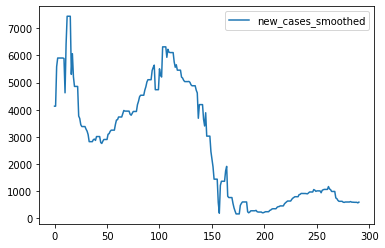

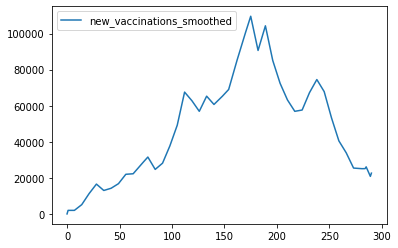

In [93]:
df_pd = df.toPandas()
df_pd[['new_cases_smoothed']].plot()
df_pd[['new_vaccinations_smoothed']].plot()

## Correlation

### New deaths

<ipython-input-107-a4c95275cfef>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(df_pd[['new_vaccinations_smoothed', 'temperature', 'rand_num_col']], df_pd[['new_deaths_smoothed']])


<BarContainer object of 3 artists>

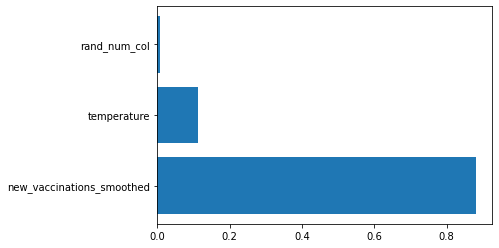

In [107]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
df_pd['rand_num_col'] = np.random.randint(1, 6, df_pd.shape[0])

model = RandomForestRegressor(n_estimators = 100)
model.fit(df_pd[['new_vaccinations_smoothed', 'temperature', 'rand_num_col']], df_pd[['new_deaths_smoothed']])
importances = model.feature_importances_

plt.barh(['new_vaccinations_smoothed', 'temperature', 'rand_num_col'], model.feature_importances_)


### New cases

<ipython-input-110-b0ca1ce377b9>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(df_pd[['new_vaccinations_smoothed', 'temperature', 'rand_num_col']], df_pd[['new_cases_smoothed']])


<BarContainer object of 3 artists>

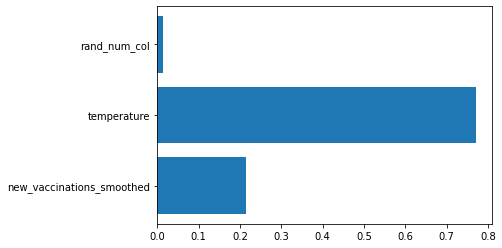

In [110]:
model = RandomForestRegressor(n_estimators = 100)
model.fit(df_pd[['new_vaccinations_smoothed', 'temperature', 'rand_num_col']], df_pd[['new_cases_smoothed']])
importances = model.feature_importances_

plt.barh(['new_vaccinations_smoothed', 'temperature', 'rand_num_col'], model.feature_importances_)

In [112]:
from sklearn.feature_selection import chi2

chi2(df_pd[['new_vaccinations_smoothed', 'temperature', 'rand_num_col']], df_pd[['new_cases_smoothed']])

ValueError: Input X must be non-negative.

In [99]:
model = RandomForestRegressor(n_estimators = 100)
model.fit(df_pd[['people_vaccinated_per_hundred', 'temperature']], df_pd[['new_cases_smoothed']])
importances = model.feature_importances_
importances

<ipython-input-99-6ecf12aa0b98>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(df_pd[['people_vaccinated_per_hundred', 'temperature']], df_pd[['new_cases_smoothed']])


array([0.04745337, 0.95254663])

TypeError: Invalid argument, not a string or column: 570.4389508964465 of type <class 'numpy.float64'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

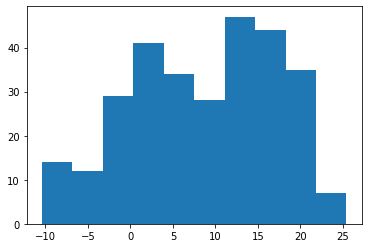

In [161]:
temp_bins = plt.hist(df_pd.temperature)
temp_bins[1]

# import scipy.stats as stats
# from sklearn.preprocessing import MaxAbsScaler

# # create an abs_scaler object
# abs_scaler = MaxAbsScaler()

# scaled_temperature = abs_scaler.fit_transform(df_pd[['temperature']]) + 1

chi2(np.array(temp_bins).reshape(-1,1), new_cases_bins)
# # temp_norm = normalize(df_pd['temperature'])

In [175]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

bins_num = 10
temp_bins = pd.cut(df_pd.temperature, bins_num, labels=[i for i in range(bins_num)])
vacc_bins = pd.cut(df_pd.new_vaccinations_smoothed, bins_num, labels=[i for i in range(bins_num)])
new_cases_bins = pd.cut(df_pd.new_cases_smoothed, bins_num, labels=[i for i in range(bins_num)])
new_deaths_bins = pd.cut(df_pd.new_deaths_smoothed, bins_num, labels=[i for i in range(bins_num)])
rand_bins = pd.cut(df_pd.rand_num_col, bins_num, labels=[i for i in range(bins_num)])

def chi2_test(df1_bins, df2_bins):
	stat, p, dof, expected = chi2_contingency(pd.crosstab(df1_bins, df2_bins))

	# interpret test-statistic
	prob = 0.95
	critical = chi2.ppf(prob, dof)
	if np.abs(stat) >= critical:
		print('Dependent (reject H0)')
	else:
		print('Independent (fail to reject H0)')

print('New cases')
print('Temperature: ', end='') 
chi2_test(temp_bins, new_cases_bins)
print('New vaccinations: ', end='') 
chi2_test(vacc_bins, new_cases_bins)
print('Random: ', end='') 
chi2_test(rand_bins, new_cases_bins)
print('New deaths')
print('Temperature: ', end='') 
chi2_test(temp_bins, new_deaths_bins)
print('New vaccinations: ', end='') 
chi2_test(vacc_bins, new_deaths_bins)
print('Random: ', end='') 
chi2_test(rand_bins, new_deaths_bins)

New cases
Temperature: Dependent (reject H0)
New vaccinations: Dependent (reject H0)
Random: Independent (fail to reject H0)
New deaths
Temperature: Dependent (reject H0)
New vaccinations: Dependent (reject H0)
Random: Independent (fail to reject H0)


In [70]:
df_pd.describe()

,temperature,new_cases,new_deaths,new_vaccinations,new_cases_smoothed,new_deaths_smoothed,new_vaccinations_smoothed
count,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000
mean,8.728522,2626.862543,22.828179,325.876289,2651.214997,23.206158,48115.099656
std,8.437415,4625.626264,61.328269,3238.937528,2079.106868,31.103372,28411.345445
min,-10.400000,0.000000,-3.000000,0.000000,168.571000,0.000000,0.000000
25%,2.550000,0.000000,0.000000,0.000000,632.143000,1.714000,24874.000000
50%,9.900000,378.000000,0.000000,0.000000,2827.286000,13.571000,53219.000000
75%,15.600000,4114.500000,19.000000,0.000000,4535.000000,23.857000,66993.500000
max,25.400000,32485.000000,474.000000,37603.000000,7441.714000,137.571000,109610.000000


,temperature,new_cases,new_deaths,new_vaccinations,new_cases_smoothed,new_deaths_smoothed,new_vaccinations_smoothed
0,3.5,0.0,0.0,0.0,4132.571,40.857,0.0
1,3.4,0.0,0.0,0.0,4132.571,40.857,1969.0
2,3.7,32485.0,0.0,0.0,5584.857,40.857,1969.0
3,1.8,8846.0,448.0,0.0,5904.429,64.000,1969.0
4,3.0,0.0,0.0,0.0,5904.429,64.000,1969.0


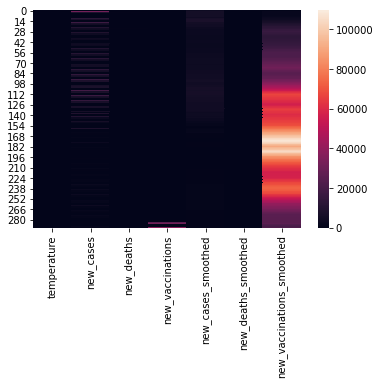

In [76]:
# import seaborn as sns
# df2 = df_pd.drop(columns=['date'], axis=1)
# ax = sns.heatmap(df2)
# df2.head()


## Get data

In [ ]:
# Weather
df_weather = pd.read_csv('data/stockholm_daily_mean_temperature.csv')
df_weather = df_weather[['date','homo']]
df_weather = df_weather.rename(columns={'homo': 'temperature'})

In [88]:
# Cases
df_cases = pd.read_csv('data/covid-data-per-country.csv')
# df_cases = df_cases[df_cases['location']=="Sweden"][['date', 'new_cases', 'new_deaths', 'new_vaccinations',  'new_cases_smoothed', 'new_deaths_smoothed', 'new_vaccinations_smoothed']]
# df_cases = df_cases.fillna(0)
df_cases.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

## Processing

In [ ]:
df = df_weather.merge(df_cases, on='date', how='inner')

<AxesSubplot:>

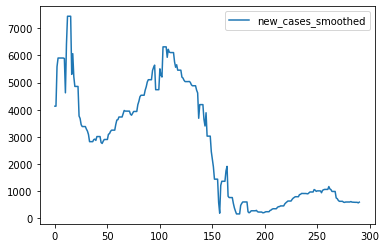

In [ ]:
df[['new_cases_smoothed']].plot()

<AxesSubplot:>

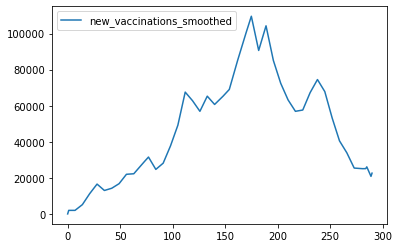

In [ ]:
df[['new_vaccinations_smoothed']].plot()